<a href="https://colab.research.google.com/github/lbuerger/IANNwTF/blob/main/homework3/hw3_bacteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
train_ds = tfds.load('genomics_ood', as_supervised =True, split='train[:100000]')
test_ds = tfds.load('genomics_ood', as_supervised =True, split='test[:1000]')

In [3]:
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))  
  return onehot

In [ ]:
train_ds = train_ds.prefetch(256)
test_ds = test_ds.prefetch(256)
train_ds_mapped = train_ds.map(lambda x, y : (onehotify(x), tf.one_hot(y,10)))
test_ds_mapped = train_ds.map(lambda x, y : (onehotify(x), tf.one_hot(y,10)))

In [5]:
#test_ds_usefull = make_usefull(test_ds)
test_ds_usefull = train_ds_mapped.batch(128).shuffle(buffer_size=128).prefetch(4)
#train_ds_usefull = make_usefull(train_ds)
train_ds_usefull = train_ds_mapped.batch(128).shuffle(buffer_size=128).prefetch(4)

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [7]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  #print(input.shape, target.shape)
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    #print(test_data)
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [9]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds_usefull, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
#print('post test')

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds_usefull, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_ds_usefull = train_ds_usefull.shuffle(buffer_size=128)
    test_ds_usefull = test_ds_usefull.shuffle(buffer_size=128)
    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds_usefull:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds_usefull, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('loss:', running_average.numpy(), 'acc:', test_accuracy)

Epoch: __ 0
loss: 1.5241557 acc: 0.33648697250639387
Epoch: __ 1
loss: 1.5057882 acc: 0.3554887308184143
Epoch: __ 2
loss: 1.5079455 acc: 0.33088235294117646
Epoch: __ 3
loss: 1.4883379 acc: 0.363960597826087
Epoch: __ 4
loss: 1.4868748 acc: 0.35288123401534527
Epoch: __ 5
loss: 1.4762919 acc: 0.3625219789002558
Epoch: __ 6
loss: 1.4495983 acc: 0.38162364130434784
Epoch: __ 7
loss: 1.469293 acc: 0.3618126598465473
Epoch: __ 8
loss: 1.4974778 acc: 0.36923553388746805
Epoch: __ 9
loss: 1.4713477 acc: 0.3712535965473146


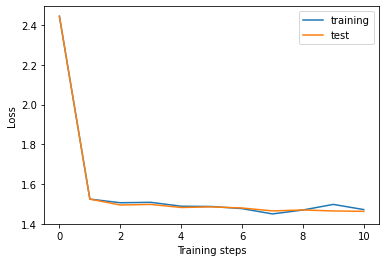

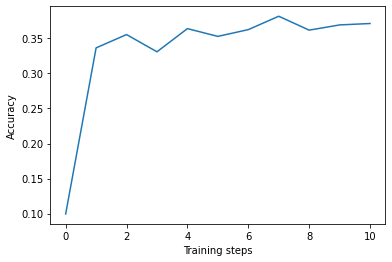

In [10]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
import matplotlib.pyplot as plt
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()